# Смотрим задачу прогнозирования временных рядом и построение ML моделей с различными алгоритмами

### Будем работать с дата-сетамом
* Прогноз продаж лекарст в сербии
Используем следующие алгоритмы:

1. Sarima
2. Prophet
3. tsfresh
4. catboost, xgboost, lgbm

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product   # аналог вложенных циклов
from tqdm import tqdm_notebook # индикации прогресса 
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): # функция вычисления ошибки
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
sns.set()

In [14]:
def up_date(): # преобразуем датафрейм
	data = pd.read_csv('salesweekly.csv')
	data['datum'] = pd.to_datetime(data.datum)
	data = data.sort_values(by='datum')
	return data

data  = up_date()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 301
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   datum   302 non-null    datetime64[ns]
 1   M01AB   302 non-null    float64       
 2   M01AE   302 non-null    float64       
 3   N02BA   302 non-null    float64       
 4   N02BE   302 non-null    float64       
 5   N05B    302 non-null    float64       
 6   N05C    302 non-null    float64       
 7   R03     302 non-null    float64       
 8   R06     302 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 23.6 KB


Посмотрим на данные

In [15]:
data.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


Объемы продаж лекарств по названию

M01AB - Противовоспалительные и противоревматические средства, нестероиды, производные уксусной кислоты и родственные вещества

M01AE - Противовоспалительные и противоревматические продукты, нестероиды, производные пропионовой кислоты

N02BA - Другие анальгетики и антипиретики, салициловая кислота и производные

N02BA - Другие анальгетики и антипиретики

N05B - Психолептики, Анксиолитические препараты

N05C - Психолептические препараты, гипнотические и седативные препараты

R06 - Антигистаминнные для постоянного использования

In [19]:
def plot_rolling(n,year = False, plot_intervals=False, scale=1.96, plot_anomalies=False,acc=[],DATE=data.datum):
    rolling_mean = acc.rolling(window=n).mean()
    plt.figure(figsize=(16,8))
    plt.grid(True)
    if year:
        plt.plot(DATE,acc[:365].values,label = 'Данные')
        plt.plot(rolling_mean[:365].values, label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    else:
        plt.plot(DATE,acc.values,label = 'Данные')
        plt.plot(DATE,rolling_mean.values, label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    # Доверительные интервалы для сглаженных значений
    if plot_intervals:
        mae = mean_absolute_error(acc[n:], rolling_mean[n:])
        deviation = np.std(acc[n:] - rolling_mean[n:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # фиксируем аномалии
        if plot_anomalies:
            anomalies = []
            indexes = []
            for i in range(len(acc)):
                if acc[i]<lower_bond[i] or acc[i]>upper_bond[i]:
                    indexes.append(i)
                    anomalies.append(acc[i])
            plt.plot(indexes,anomalies, "ro", markersize=10)
        
    plt.legend()
    plt.show()

#### Рисуем график по антигистаминным

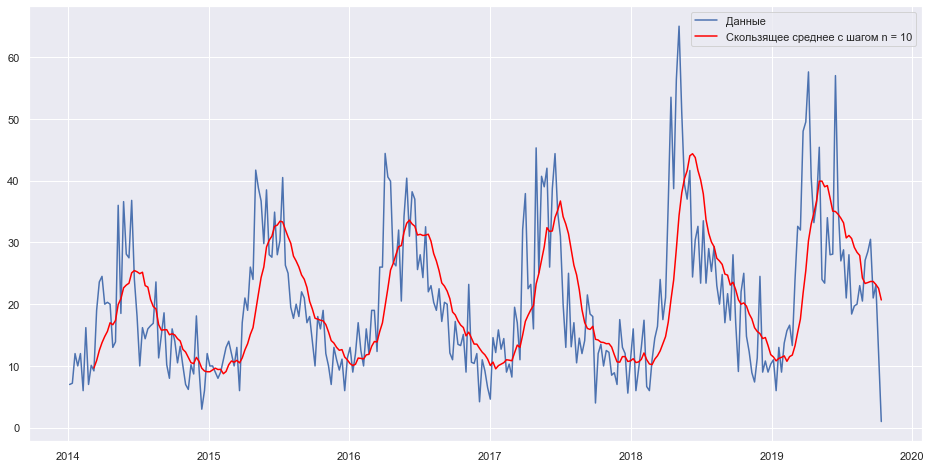

In [20]:
plot_rolling(10, acc = data.R06) #посмотрим антигистаминные

Видим, что объемы продаж повышаются летом, видимо больше причин для аллергии

### Импортируем пакеты для статистики и эконометрики

In [22]:
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

## Пробуем метод SARIMA
### Суть - используем данные из прошлого на основе авторегрессии и учета сезонности

Напишем функцию для отображения графика

In [24]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
      График временных рядов методами ACF (автокорреляция между временным сигналом и его задержанной версией)
		 отображает коэффициент корреляции в зависимости от запаздывания и является визуальным представлением автокорреляции
		PACF (частичная автокорреляция) - прямая корреляци между временными рядами и собственной версией с запаздыванием
		Анализируем для того, чтобы понять можно ли использовать SARIMA
		
		ACF поможет нам определить q (порядок компоненты MA), т. к. по ее коррелограмме можно определить количество 
		автокорреляционных коэффициентов сильно отличных от 0 в модели MA
		PACF поможет нам определить p (порядок компоненты AR), т. к. 
		по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
      
        y - временные ряды
        lags - сколько лагов включить в ACF и PASF
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

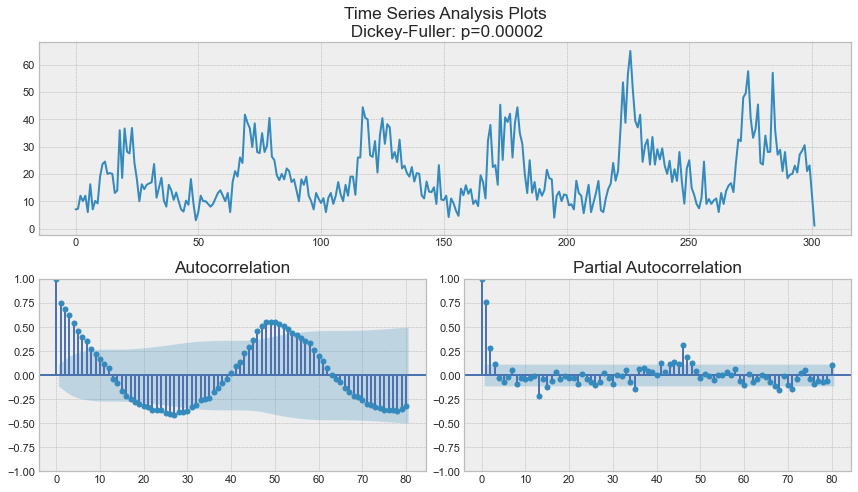

In [25]:
amount0 = data.R06
tsplot(amount0,80)

На графике слева видим, что данные периодичны, 

Попробуем привести наш ряд к белому шуму, желательно стационарному. Белый шум - это ряд со случайными значениями
которые имеют одинаковую дисперсию, которые колеблются вокруг одного среднего.

Наша задача путем численного диффер или единичных вычислении привести ряд к белому шуму

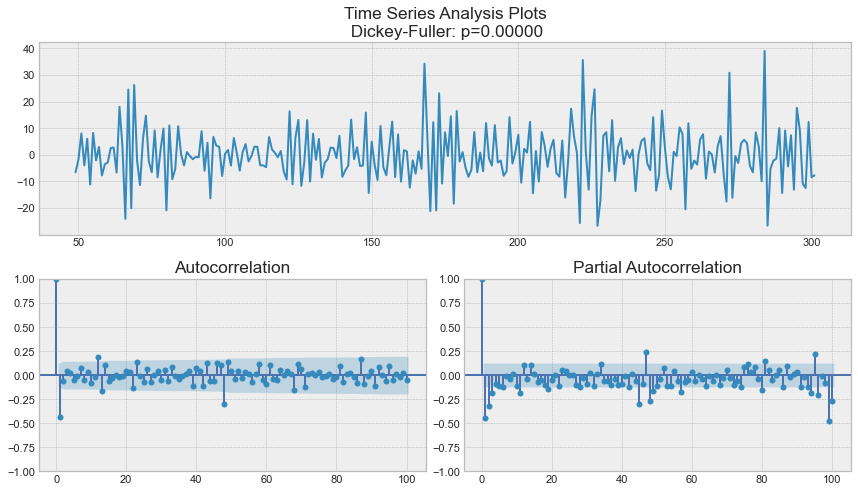

In [27]:
amount1 = amount0 - amount0.shift(48) # сдвигаем исходный рад на 48 значений, так как на график 1 видно, что 48 лаг - это максимум ACF
amount2 = amount1 - amount1.shift(1)
amount3 = amount2 - amount2.shift(1)
amount4 = amount3 - amount3.shift(1)
amount5 = amount4 - amount4.shift(1)
#amount6 = amount5 - amount5.shift(1)
#amount7 = amount6 - amount6.shift(21)
tsplot(amount2[49:],100)

Для модели SARIMA нужен подбор параметров

p = 3, примерный лаг, после которого автокорреляция равно нулю (график 2 правый нижний)
q = 1, аналогично смотрим на левый нижний график
d = 1, сколько единичных разностей было взято
s = 48, сезонность
P = 1, нижний правый, номер сезонного лага, после которого сезонные лаги равны нулю (нижний правый)
Q = 1
D = 1

In [28]:
# попробуем варьировать значения для SARIMA
ps = range(2, 5)
d=1 
qs = range(0, 3)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 48

# создаем список со всеми возможными параметрами
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

Функция для оптимизации модели и подбора параметра

In [29]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Подаем список с параметрами parameters_list

    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # пробуем разные комбинации, потому что на некоторых параметром модель может не сходится
        try:
            model=sm.tsa.statespace.SARIMAX(data.R06, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # сохраняем лучшую модель
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # отсортируем по лучшей модели
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [ ]:
result_table.head(7) # таблица результатом с отсортированными параметрами

лучшие параметры 
p = 3, q = 1, P = 0, Q = 1

Посмтроим модель на основе стат методов


In [30]:
p, q, P, Q = 3,1,0,1

best_model=sm.tsa.statespace.SARIMAX(data.R06, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                R06   No. Observations:                  302
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 48)   Log Likelihood                -883.025
Date:                            Sun, 05 Jun 2022   AIC                           1778.051
Time:                                    18:33:36   BIC                           1799.251
Sample:                                         0   HQIC                          1786.580
                                            - 302                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3584      0.058      6.164      0.000       0.244       0.472
ar.L2          0.1926      0.062   

Результаты по прохождению модели различных тестов

Визиализируем

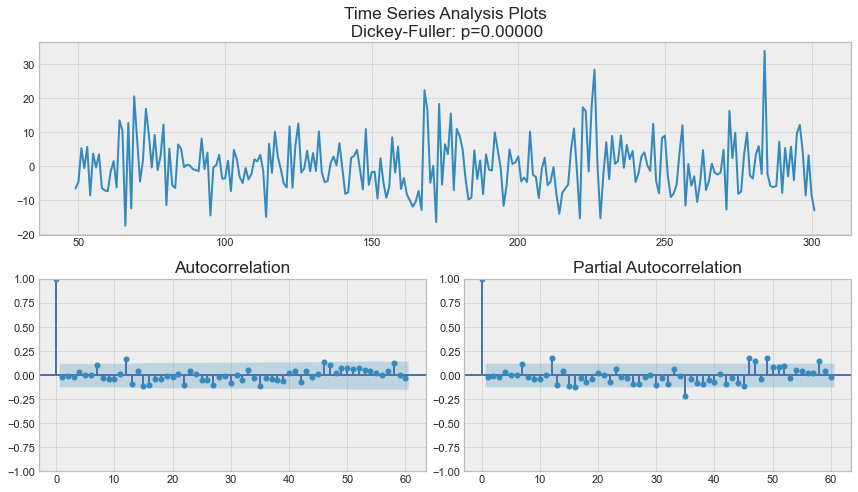

In [31]:
tsplot(best_model.resid[48+1:], lags=60)

Строим прогноз, для этого пишем функцию

In [32]:
def plotSARIMA(series, model, n_steps, s=48, d=1, plot_intervals=True, alpha=0.2):
    """
        Графики и предсказание модели
        
        series - набор данных с рядами
        model - обученная модель SARIMA
        n_steps - количестов шагов для предсказания будущего
        
    """
    # добавление значений модели
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # сдвиг на s+d шагов, так как эти значения не учитывались моделью
    # в силу дифференциации
    data['arima_model'][:s+d] = np.NaN
    # предсказание на шаг n_steps  
    forecast = best_model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # предсказываем на s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'], 
                         y2=intervals['lower'], alpha=0.2, color = "grey")    
    
    
    plt.legend()
    plt.grid(True);

In [33]:
mask = ['R06']

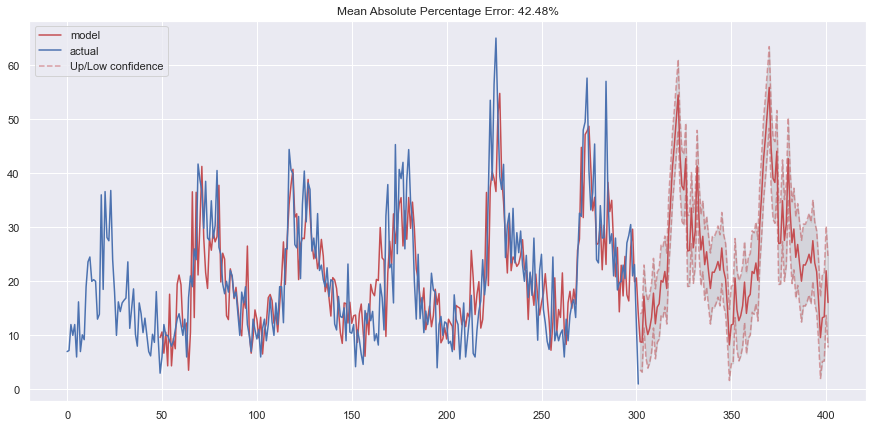

In [34]:
plotSARIMA(data[mask], best_model, 100, alpha=0.5)

Ошибка составила 42,48% - это много.
SARIMA может предсказывать на необпределенное число шагов вперед, хорошо работает с трендами, но дает высокую ошибку, и долго настраивается

## Градиентый бустинг

In [39]:
# Добавление отставания целевой переменной от 100 шагов назад до 400
data = pd.DataFrame(data.R06.copy())
data.columns = ["y"]
vals = list(range(1,11))+list(range(49,54))
for i in vals:
    data["lag_{}".format(i)] = data.y.shift(i)
# посмотрите на новую дату 
data.tail(7)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_49,lag_50,lag_51,lag_52,lag_53
295,27.10,20.50,23.0,20.0,19.7,18.4,28.0,21.0,28.8,27.0,35.94,28.0,17.4,21.7,17.0,24.8
296,28.50,27.10,20.5,23.0,20.0,19.7,18.4,28.0,21.0,28.8,27.00,17.0,28.0,17.4,21.7,17.0
297,30.50,28.50,27.1,20.5,23.0,20.0,19.7,18.4,28.0,21.0,28.80,9.1,17.0,28.0,17.4,21.7
298,21.00,30.50,28.5,27.1,20.5,23.0,20.0,19.7,18.4,28.0,21.00,22.0,9.1,17.0,28.0,17.4
299,23.10,21.00,30.5,28.5,27.1,20.5,23.0,20.0,19.7,18.4,28.00,25.0,22.0,9.1,17.0,28.0
300,12.13,23.10,21.0,30.5,28.5,27.1,20.5,23.0,20.0,19.7,18.40,14.8,25.0,22.0,9.1,17.0
301,1.00,12.13,23.1,21.0,30.5,28.5,27.1,20.5,23.0,20.0,19.70,12.3,14.8,25.0,22.0,9.1


При работе с временными рядами необходимо сохранять последователность точек. Именно для этого применяется кросс-валидация.



In [40]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor # бустинг не чуствителен к тренду
from sklearn.preprocessing import StandardScaler

# при перекрестной проверки установим 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [41]:
def timeseries_train_test_split(X, y, test_size):
    """
        Функция по разбивке временных рядов, сохраняя структуру
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

Разделим данные на у - целевую переменную и множество независимых переменных Х

In [42]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# сохраним 30% для теста
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [45]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Диаграммы фактические и смоделированные, предсказание интервалов и аномалий
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model,normas = True):
    """
        графики отсортированных значений
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    if normas:
        coefs = coefs.loc[coefs.ne(0).all(axis=1)]
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

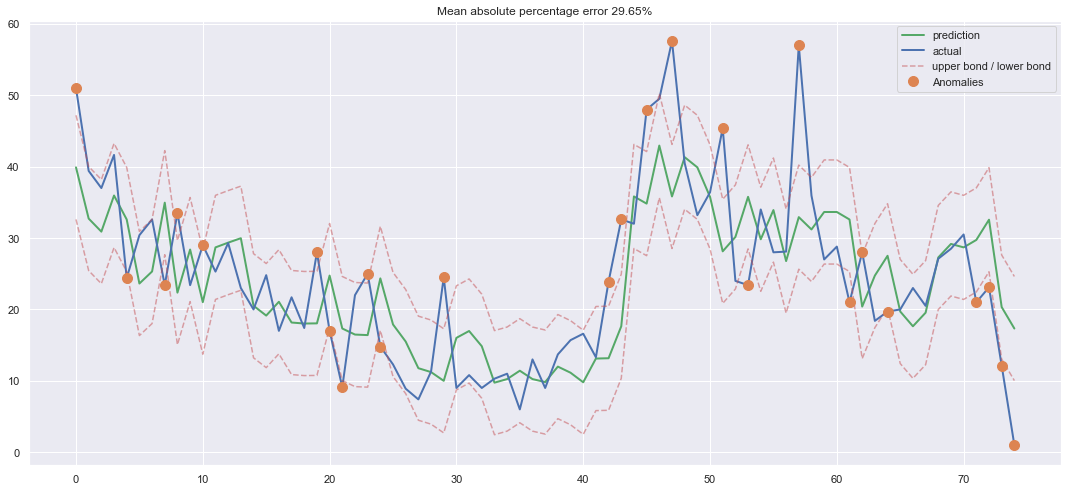

In [46]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor # бустинг не чуствителен к тренду
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

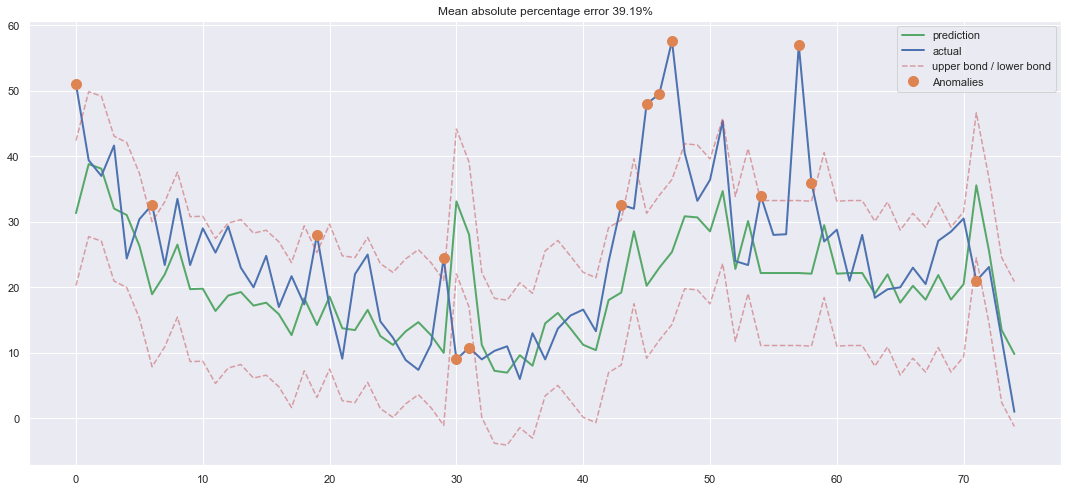

In [47]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor(iterations=100, learning_rate=0.7,
                          loss_function='MAPE', verbose=0)

catboost.fit(X_train_scaled, y_train, verbose=0)

plotModelResults(catboost, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

Библиотека Prophet от Facebook

вопросы с установкой библиотеки

In [57]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'